In [229]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features
from tabulate import tabulate
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
print(len(btests))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
32


In [230]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 64
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    # print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    # print(len(btest.positions))
    for pos in btest.positions[4:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

(10343, 1, 9, 64) (10343,)
20180600 -> 20201230


In [172]:
def smooth_bin_labels(y, dp=0.3):
    y = y.astype(float)
    d = np.random.uniform(0, dp, sum(y[:, 0]==0))
    y[y[:, 0]==0, 0] = d
    y[y[:, 1]==1, 1] = 1-d
    return y

def smooth_prob_labels(y, dp=0.1):
    y = y.astype(float)
    d = np.random.uniform(-dp, dp, sum(y[:, 0]==0))
    y += dp
    return y

def stohastic_prediction(input_tensor):
    pmeans, pstds, ymeans = np.zeros((3, input_tensor.shape[0]))
    for i, x in enumerate(input_tensor):
        p = model(torch.stack([x]*100)).detach().cpu().numpy()[:, 0]
        pmeans[i] = p.mean()
        pstds[i] = p.std()
    return pmeans, pstds

def calc_weights(predicts, th):
    #return predicts > th
    return np.clip((predicts+th)**30, 0, 1)

  iter    pboost    pboost mean    pboost median    pboost std
------  --------  -------------  ---------------  ------------
     0   1.072          1.072            1.072         0
     1   5.22823        3.15011          3.15011       2.07812
     2   1.54199        2.61407          1.54199       1.85842
     3   2.17419        2.5041           1.85809       1.62067
     4   1.16722        2.23672          1.54199       1.54506
     5   1.32999        2.0856           1.43599       1.45036
     6   1.01418        1.93254          1.32999       1.39413
     7   1.2634         1.8489           1.2967        1.32273
     8   1.18998        1.77569          1.2634        1.26416
     9   1.12883        1.711            1.22669       1.21489


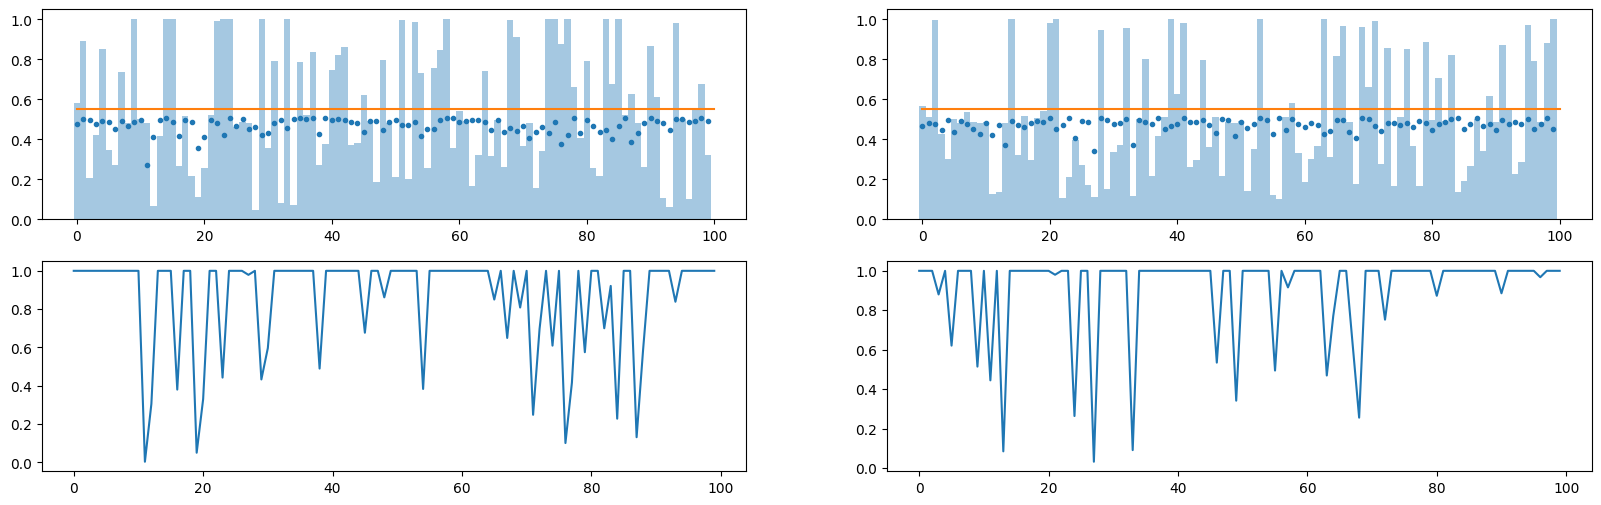

In [227]:
from sklearn.metrics import f1_score
import torch
device = "mps"

nitrers = 10
test_split_size = 0.2
calc_test = False
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(nitrers):
    if i >= 0:
        np.random.seed(i)
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split_size)
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    # model = train(X_train, y_train, X_test, y_test, batch_size=512, device=device, calc_test=calc_test)
    model.eval()
    p_test = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
    # for m in range(9):
    #     np.random.seed(i+10)
    #     model = train(X_train, y_train, X_test, smooth_prob_labels(y_test), batch_size=256, device=device, calc_test=False)
    #     model.eval()
    #     p_test_ = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    #     p_train_ = model(X_train[:y_test.shape[0]]).detach().cpu().numpy().squeeze()[:, 0] 
    #     p_test = (p_test + p_test_)/2
    #     p_train = (p_train + p_train_)/2
        
    profsum_best, threshold = -999999, np.percentile(p_train, 20)
    for th in np.arange(0.1, 1, 0.05):
        w_profs_train = calc_weights(p_train, th)
        profsum = (profs_train*w_profs_train).sum()
        if profsum > profsum_best:
            profsum_best = profsum
            threshold = th
    w_profs_train = calc_weights(p_train, threshold)
    metrics[0, i] = f1_score(p_train>0.5, y_train[:, 0]>0.5)
    # print(f"{i:03} f1_train: {metrics[0, i]:5.3f}", end=" ")
    
    if test_split_size > 0:
        metrics[1, i] = f1_score(p_test>0.5, y_test[:, 0]>0.5)
        # print(f"f1_test: {metrics[1, i]:5.3f}")
        w_profs_test = calc_weights(p_test, threshold)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*w_profs_test[ids]).sum()
            gprofits[j, i] = profs_test[ids].sum()
            # print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        
        prof_boost_mean = np.nanmean(pprofits[:, :i+1]/gprofits[:, :i+1])
        prof_boost_median = np.nanmedian((pprofits[:, :i+1]/gprofits[:, :i+1]))
        prof_boost_std = np.nanstd(pprofits[:, :i+1]/gprofits[:, :i+1])
        clear_output(wait=True)
        table.append([i, np.nanmean(pprofits[:, i]/gprofits[:, i]), prof_boost_mean, prof_boost_median, prof_boost_std])
        print(tabulate(table, headers=["iter", "pboost", "pboost mean", "pboost median", "pboost std"]))
        
        # print(f"profit boost mean: {prof_boost_mean}")
        # print(f"profit boost median: {prof_boost_median}")        
        # print(f"profit boost std: {prof_boost_std}")
        # metrics_mean, metrics_std = metrics.mean(1, where=metrics!=0), metrics.std(1, where=metrics!=0)
        # print(f"metrics train/val means: {metrics_mean}, std: {metrics_std}")
        # print(f"overfitting mean: {metrics_mean[0]/metrics_mean[1]}, std: {metrics_std[0]/metrics_std[1]}\n")

    else:
        print()
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(2, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    plt.subplot(2, 2, 3)
    plt.plot(w_profs_train[:100])
    plt.subplot(2, 2, 4)
    plt.plot(w_profs_test[:100])
    # plt.plot(profs_test[:100]*w_profs_test[:100])
    # plt.plot(profs_test[:100], linewidth=3, alpha=0.5)  
    
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

In [ ]:
import torch
from ml import Net
device = "mps"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
# model.eval()
model.to(device)

In [ ]:
def stohastic_prediction(input_tensor):
    pmeans, pstds, ymeans = np.zeros((3, input_tensor.shape[0]))
    for i, x in enumerate(input_tensor):
        p = model(torch.stack([x]*100)).detach().cpu().numpy()[:, 0]
        pmeans[i] = np.median(p)
        pstds[i] = p.std()
        ymeans[i] = (pmeans[i] > 0.48) == y_test[i, 0]
    return pmeans, pstds, ymeans

pmeans, pstds, ymeans = stohastic_prediction(torch.tensor(X_test[:100]).float().to(device))
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
plt.plot(pmeans, ".")
plt.subplot(1, 3, 2)
plt.plot(pstds, ".")
plt.subplot(1, 3, 3)
plt.plot(ymeans, ".")

In [ ]:
pprofits[2]

In [221]:
np.nanmean(pprofits[:, :i+1]/gprofits[:, :i+1])

1.0719981933079055

In [196]:
np.median((pprofits[:, :i]/gprofits[:, :i]), axis=1)

array([       nan,        nan, 1.17894395])

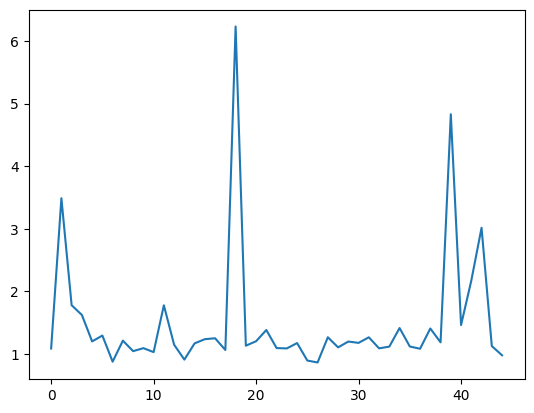

In [191]:
plt.plot(pprofits[2]/gprofits[2])

In [ ]:
p_train.mean(), threshold

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction